# Dipendenze

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install pillow numpy matplotlib tensorflow[and-cuda]

# Imports

In [1]:
import os
import time
import math
import zipfile
import random
import itertools
import pathlib
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import PIL.Image as pillow

2025-01-22 14:04:57.175107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737554697.196445     327 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737554697.201996     327 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 14:04:57.225230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
print(f"TensorFlow version: {tf.__version__}")
for i, dev in enumerate(tf.config.list_physical_devices(device_type="GPU")):
    print(f"\t* Available {dev.device_type} #{i}: {dev.name}")

TensorFlow version: 2.18.0
	* Available GPU #0: /physical_device:GPU:0


# Estrazione del dataset

In [3]:
DATASET_ZIP_PATH="animals.zip"
DATASET_IMGS_DESTDIR="./"

if not os.path.isdir(DATASET_IMGS_DESTDIR + "animals"):
    if not os.path.isfile(DATASET_ZIP_PATH):
        raise FileNotFoundError(f" !! Unable to continue, could not find zipped dataset to extract dataset from: {DATASET_ZIP_PATH}")

    with zipfile.ZipFile(DATASET_ZIP_PATH, mode="r") as animalz:
        animalz.extractall(DATASET_IMGS_DESTDIR)

### Calcolo della media della dimensione delle immagini del dataset

In [4]:
ws = []
hs = []

start = time.time()

for root, dirs, files in os.walk(DATASET_IMGS_DESTDIR + "animals"):
    path = root.split(os.sep)
    for file in files:
        mypath = f"{DATASET_IMGS_DESTDIR}animals/{os.path.basename(root)}/{file}"
        img = pillow.open(mypath)
        w,h = img.size
        ws.append(w)
        hs.append(h)
        
avg = lambda n: sum(n) / len(n)

avg_w = int(avg(ws))
avg_h = int(avg(hs))

end = time.time()

print(f"done. it took {end - start:.2f} secs.\navg_w = {avg_w}, avg_h = {avg_h}")

done. it took 29.17 secs.
avg_w = 319, avg_h = 252


# Caricamento del dataset e split

In [5]:
INPUT_SHAPE=(avg_w, avg_w, 3)
BATCH_SIZE=16

training_set, testing_set = keras.utils.image_dataset_from_directory(
    DATASET_IMGS_DESTDIR + "animals",
    subset="both",
    seed=1234,
    validation_split=0.3,
    image_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    label_mode="categorical",
    batch_size=BATCH_SIZE)

training_set_size = int(0.8 * len(training_set))
validation_set_size = int(0.2 * len(training_set))
__Training_set = training_set.take(training_set_size)
validation_set = training_set.skip(training_set_size).take(validation_set_size)
training_set = __Training_set

print(f"num of training set batches: {len(training_set)} so {len(training_set) * BATCH_SIZE} elems")
print(f"num of validation set batches: {len(validation_set)} so {len(validation_set) * BATCH_SIZE} elems")
print(f"num of testing set batches: {len(testing_set)} so {len(testing_set) * BATCH_SIZE} elems")

dataset_labels = {
        0 : "cane",
        1 : "cavallo",
        2 : "elefante",
        3 : "farfalla",
        4 : "gallina",
        5 : "gatto",
        6 : "mucca",
        7 : "pecora",
        8 : "ragno",
        9 : "scoiattolo"
    }

Found 26128 files belonging to 10 classes.
Using 18290 files for training.
Using 7838 files for validation.


I0000 00:00:1737554741.314295     327 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


num of training set batches: 915 so 14640 elems
num of validation set batches: 228 so 3648 elems
num of testing set batches: 490 so 7840 elems


# Common utils

In [ ]:
class CommonUtils:
    to_ms = lambda t : math.ceil(t * 1000)

    get_file_size = lambda fname : os.path.getsize(fname) / (1024 * 1024)

    pretty_model_size = lambda wfname : "model size: " +
                                    f"{CommonUtils.get_file_size(wfname):.2f} MB"

    pretty_evaluate = lambda ev : f"loss: {ev[0]} - categorical_accuracy: {ev[1]}"
    
    @staticmethod
    def __base_predict_3x3_from_dataset__(dataset, m, predict_hook):
        shuffled_dataset = dataset.unbatch().shuffle(buffer_size=10)
        plt.figure(figsize=(10, 10))
        for i, t in itertools.islice(enumerate(shuffled_dataset), 0, 9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(t[0].numpy().astype("uint8"))
            y = predict_hook(t[0], m)
            plt.title(dataset_labels[np.argmax(y)])
            plt.axis("off")
    
    @staticmethod
    def __base_evaluate__(dataset, batch_size, predict_hook, framework_name, log_every):
        def log_eval_stats_sofar(end_trecord, final_log=False):
            print(f"evaluating {framework_name} model - "+
                  f"{i+1}/{total_evals} ({math.floor(((i+1)/total_evals) * 100)}%) - " + 
                  f"cce_loss: {kcce(acc_ts, acc_ys):.4f}, " +
                  f"ca_metric: {kca.result():.4f} - "+
                  f"avg infer time: {CommonUtils.to_ms(avg(infer_times))} ms - "+
                  f"elapsed wall clock time: {end_trecord - start:.2f}s ", 
                  end="\n" if final_log else "\r")
            
        acc_ys = []
        acc_ts = []
        infer_times = []

        audit = log_every > 0
        
        total_evals = batch_size * len(dataset)
        kca = keras.metrics.CategoricalAccuracy()
        kcce = keras.losses.CategoricalCrossentropy()

        if audit:
            print("preparing, please wait...", end="\r")

        start = 0
            
        for i, e in enumerate(dataset.unbatch()):
            if i == 0:
                start = time.time()
                if audit:
                    print("evaluation has started (timer *now* ticking), stats will be available asap...", end="\r")
                    
            y, infer_time = predict_hook(e[0])

            acc_ys.append(y)
            acc_ts.append(e[1])
            infer_times.append(infer_time)
            kca.update_state([e[1]], [y])

            if audit and (i+1) % log_every == 0:
                log_eval_stats_sofar(time.time())

        end = time.time()
        
        if audit:
            i = total_evals - 1 
            log_eval_stats_sofar(end, True)

        return float(kcce(acc_ts, acc_ys)), float(kca.result()), avg(infer_times), end - start

# Helper per transfer learning

In [84]:
class TransferLearning:
    STR_NO_MODEL = "model has not been built"
    
    def __init__(self, base_model, user_name):
        self.base_model = base_model
        self.model = None
        self.full_name = f"{user_name}_{base_model().name}"
        self.weights_filename = f"./{self.full_name}_tl.weights.h5"
        self.user_name = user_name
        
    # you should not override this
    def load_weights_from_file(self):
        if self.model:
            if os.path.isfile(self.weights_filename):
                self.model.load_weights(self.weights_filename)
                print(f"loaded weights: {self.weights_filename}")
            else:
                raise FileNotFoundError(f"unable to load weights - cannot find: {self.weights_filename}")
        else:
            raise RuntimeError(STR_NO_MODEL)

    # you should not override this
    def save_weights_to_file(self):
        if self.model:
            self.model.save_weights(self.weights_filename)
            print(f"done: {self.weights_filename}")
        else:
            raise RuntimeError(STR_NO_MODEL)

    # you should not override this
    def build_model(self, *args, **kwargs):
        top_layers = 0

        def atlay(x):
            nonlocal top_layers
            top_layers += 1
            return x
        
        defd_model = self.__define_model(atlay, *args, **kwargs)
    
        freezing_layers = defd_model.layers[:len(defd_model.layers) - top_layers]
        for layer in freezing_layers:
            layer.trainable = False

        self.model = defd_model

    # you may override this
    # private (let's say "protected")
    def __define_model(self, add_top_layer, *args, **kwargs):
        return keras.Sequential([
                keras.Input(shape=args[0]),
                keras.layers.Rescaling(scale=1./127.5, offset=-1),
                self.base_model(include_top=False, input_shape=args[0]),
                add_top_layer(keras.layers.GlobalAveragePooling2D()),
                add_top_layer(keras.layers.Dropout(0.25)),
                add_top_layer(keras.layers.Dense(
                    10,
                    bias_initializer=keras.initializers.GlorotUniform(),
                    activation=keras.activations.softmax))
                ], name=self.user_name)

    # you may override this
    def compile_model(self, *args, **kwargs):
        self.model.compile(
                optimizer=keras.optimizers.Adam(),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=[
                    keras.metrics.CategoricalAccuracy()
                ])

    # you may override this
    def fit_model(self, *args, **kwargs):
        return self.model.fit(
                args[0],
                validation_data=args[1],
                validation_freq=3,
                epochs=40,
                callbacks=[
                    keras.callbacks.EarlyStopping(
                        start_from_epoch=3,
                        patience=2,
                        restore_best_weights=True),
                    keras.callbacks.LearningRateScheduler(
                        lambda e, l: l if e < 1 else l * np.exp(-0.15)
                )])

    def __call__(self, inp, audit=True):
        hrt_start = time.perf_counter()
        y_pred = self.model(inp)
        hrt_end = time.perf_counter()
        
        if audit:
            print("hres-timer inference time elapsed wall clock:" + 
                  f" {CommonUtils.to_ms(hrt_end - hrt_start)}ms")
            
        return y_pred, hrt_end - hrt_start

    def evaluate(self, dataset, batch_size, input_shape, log_every=150):
        def predict(e):
            r = self(TransferLearning.preprocess(e, input_shape), False)
            return tf.reshape(r[0], (10,)), r[1]
            
        return CommonUtils.__base_evaluate__(dataset, batch_size, predict, 
                                             "tf", log_every)
            
    @staticmethod
    def preprocess(img, input_shape):
        resized = tf.image.resize([img], (input_shape[0], input_shape[1]))
        return tf.reshape(resized, (1, input_shape[0], input_shape[1], input_shape[2]))

# Primo modello preaddestrato: ```MobileNet```

## Transfer learning

### Build

In [85]:
tl_first = TransferLearning(keras.applications.MobileNet, "first")
tl_first.build_model(INPUT_SHAPE)
tl_first.model.summary()

/tmp/ipykernel_327/4146379720.py:53: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  self.base_model(include_top=False, input_shape=args[0]),


Model: "first"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 319, 319, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 10, 10, 1024)   │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,239,114 (12.36 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

### Ripristino dei pesi da file (se presenti)

In [86]:
try:
    tl_first.load_weights_from_file()
except FileNotFoundError as e:
    print(e)

loaded weights: ./first_mobilenet_1.00_224_tl.weights.h5


### Addestramento del modello

In [87]:
tl_first.compile_model()

In [10]:
tl_first.fit_model(training_set, validation_set)

Epoch 1/40


I0000 00:00:1737554745.211010     412 service.cc:148] XLA service 0x7fa300023ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737554745.211055     412 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-01-22 14:05:45.352767: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737554745.649658     412 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1737554746.716046     412 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737554746.864747     412 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 13/915 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - categorical_accuracy: 0.2031 - loss: 2.6979  

I0000 00:00:1737554748.476133     412 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


915/915 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - categorical_accuracy: 0.7651 - loss: 0.7714 - learning_rate: 0.0010
Epoch 2/40
  8/915 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - categorical_accuracy: 0.9248 - loss: 0.2505

/home/jupyter/.local/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: categorical_accuracy,loss
  current = self.get_monitor_value(logs)


915/915 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - categorical_accuracy: 0.9461 - loss: 0.1802 - learning_rate: 8.6071e-04
Epoch 3/40
914/915 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9557 - loss: 0.1460 

2025-01-22 14:06:35.876132: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_698', 108 bytes spill stores, 108 bytes spill loads



915/915 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - categorical_accuracy: 0.9557 - loss: 0.1460 - val_categorical_accuracy: 0.9644 - val_loss: 0.1227 - learning_rate: 7.4082e-04
Epoch 4/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - categorical_accuracy: 0.9580 - loss: 0.1369 - learning_rate: 6.3763e-04
Epoch 5/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - categorical_accuracy: 0.9609 - loss: 0.1209 - learning_rate: 5.4881e-04
Epoch 6/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - categorical_accuracy: 0.9650 - loss: 0.1166 - val_categorical_accuracy: 0.9644 - val_loss: 0.1248 - learning_rate: 4.7237e-04
Epoch 7/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - categorical_accuracy: 0.9692 - loss: 0.1036 - learning_rate: 4.0657e-04
Epoch 8/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - categorical_accuracy: 0.9707 - loss: 0.1021 - learning_rate: 3.4994e-04
Epoch 9/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - categorical_accuracy: 0.9721 - loss: 0.0940 - val_categorical_accuracy: 0.9704 

### Salvataggio pesi correnti

In [11]:
tl_first.save_weights_to_file()
time.sleep(5)

done: ./first_mobilenet_1.00_224_tl.weights.h5


### Provare a fare predizioni

In [88]:
def predict_3x3_from_dataset(dataset, modl):
    CommonUtils.__base_predict_3x3_from_dataset__(
        dataset,
        modl,
        lambda d, m : m(TransferLearning.preprocess(d, INPUT_SHAPE))[0])

hres-timer inference time elapsed wall clock: 162ms
hres-timer inference time elapsed wall clock: 60ms
hres-timer inference time elapsed wall clock: 59ms
hres-timer inference time elapsed wall clock: 60ms
hres-timer inference time elapsed wall clock: 60ms
hres-timer inference time elapsed wall clock: 59ms
hres-timer inference time elapsed wall clock: 72ms
hres-timer inference time elapsed wall clock: 59ms
hres-timer inference time elapsed wall clock: 60ms


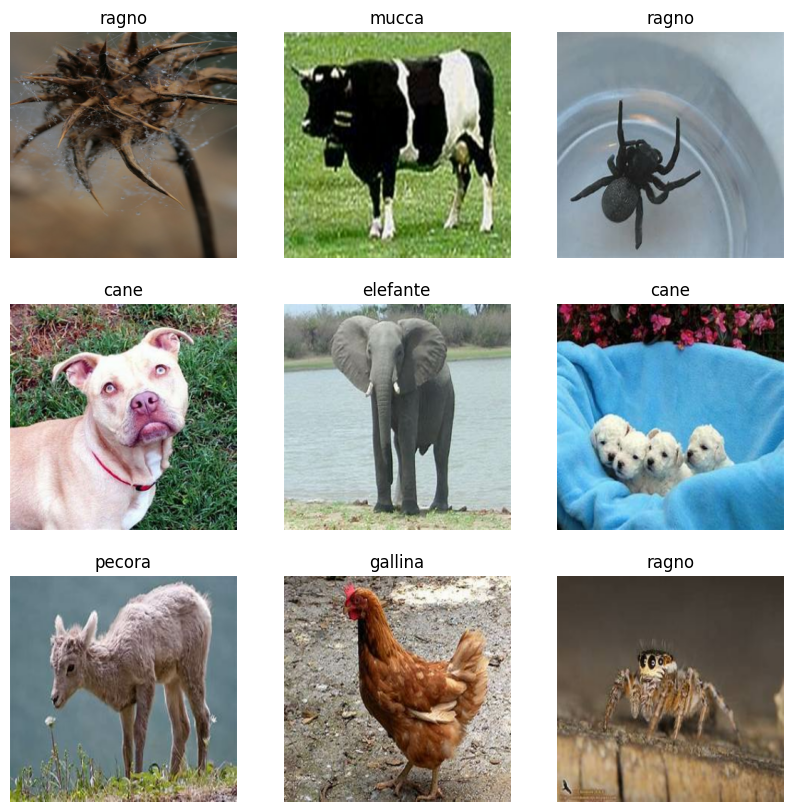

In [89]:
predict_3x3_from_dataset(validation_set, tl_first)

### Metriche del modello ottenuto

## Quantizzazione

### Helpers per TensorFlow Lite / LiteRT

In [92]:
class TFLiteUtils:
    preprocess = lambda i : tf.image.resize(i, (avg_w, avg_w))
        
    @staticmethod
    def predict(tflite_file, img, audit=False):
        interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
        interpreter.allocate_tensors()

        input_details = interpreter.get_input_details()[0]
        output_details = interpreter.get_output_details()[0]
        
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            img = img / input_scale + input_zero_point
            
        _img = np.expand_dims(img, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], _img)

        hrt_start = time.perf_counter()
        interpreter.invoke()
        hrt_end = time.perf_counter()

        if audit:
            print("hres-timer inference time elapsed wall clock: "
                  +f"{CommonUtils.to_ms(hrt_end - hrt_start)}ms")
        
        return interpreter.get_tensor(output_details["index"])[0], hrt_end - hrt_start

    @staticmethod
    def evaluate(tflite_file, dataset, batch_size, log_every=150):
        return CommonUtils.__base_evaluate__(dataset, batch_size, 
            lambda elem : 
                TFLiteUtils.predict(tflite_file, TFLiteUtils.preprocess(elem)), 
            "tflite", log_every)

    @staticmethod
    def get_model_path(tflite_model_name):
        tflite_models_dir = pathlib.Path("./")
        tflite_models_dir.mkdir(exist_ok=True, parents=True)
        return tflite_models_dir/f"{tflite_model_name}.tflite"

    @staticmethod
    def save_tofile(tflite_model_name, tflite_model):
        path = TFLiteUtils.get_model_path(tflite_model_name)
        path.write_bytes(tflite_model)
        print(f"saved tflite model: {str(path)}")
        return str(path)

    class Conversion:
        get_basic_name = lambda your_name : f"{your_name}_basic"
        get_weights_only_name = lambda your_name : f"{your_name}_weights_only"
        get_partially_full_name = lambda your_name : f"{your_name}_partially_full"
        get_full_name = lambda your_name : f"{your_name}_full"
        
        #private
        @staticmethod
        def __representative_data_gen(trset):
            for xinput, _ in trset.unbatch().take(500):
                yield [tf.expand_dims(xinput, axis=0)]

        # no quantization applied here
        @staticmethod
        def basic(keras_model):
            converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
            
            return converter.convert()

        @staticmethod
        def weights_only_quant(keras_model):
            converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            
            return converter.convert()
            
        @staticmethod
        def partially_full_quant(keras_model, trset):
            converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.representative_dataset = lambda : TFLiteUtils.Conversion.__representative_data_gen(trset)

            return converter.convert()
            
        @staticmethod
        def full_quant(keras_model, trset):
            converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.representative_dataset = lambda : TFLiteUtils.Conversion.__representative_data_gen(trset)
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            converter.inference_input_type = tf.uint8
            converter.inference_output_type = tf.uint8
            
            return converter.convert()

def predict_3x3_from_dataset_tflite(dataset, modl):
    CommonUtils.__base_predict_3x3_from_dataset__(
        dataset,
        lambda i, m : TFLiteUtils.predict(
            TFLiteUtils.get_model_path(m), 
            TFLiteUtils.preprocess(i.numpy()), True)[0],
        predict)

### Applicazione (dal livello più debole a quello più forte)

In [16]:
first_basic_tflite_name = TFLiteUtils.Conversion.get_basic_name(tl_first.full_name)
first_weights_only_quant_tflite_name = TFLiteUtils.Conversion.get_weights_only_name(tl_first.full_name)
first_partially_full_quant_tflite_name = TFLiteUtils.Conversion.get_partially_full_name(tl_first.full_name)
first_full_quant_tflite_name = TFLiteUtils.Conversion.get_full_name(tl_first.full_name)